# SARIMAX
Author: Geovanna Santos Nobre de Oliveira

# SARIMAX

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] =[20,10]

## United States Macroeconomic Dataset

In [4]:
macro_data = sm.datasets.macrodata.load_pandas()

In [5]:
macro_data.data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


In [6]:
macro_data = macro_data.data

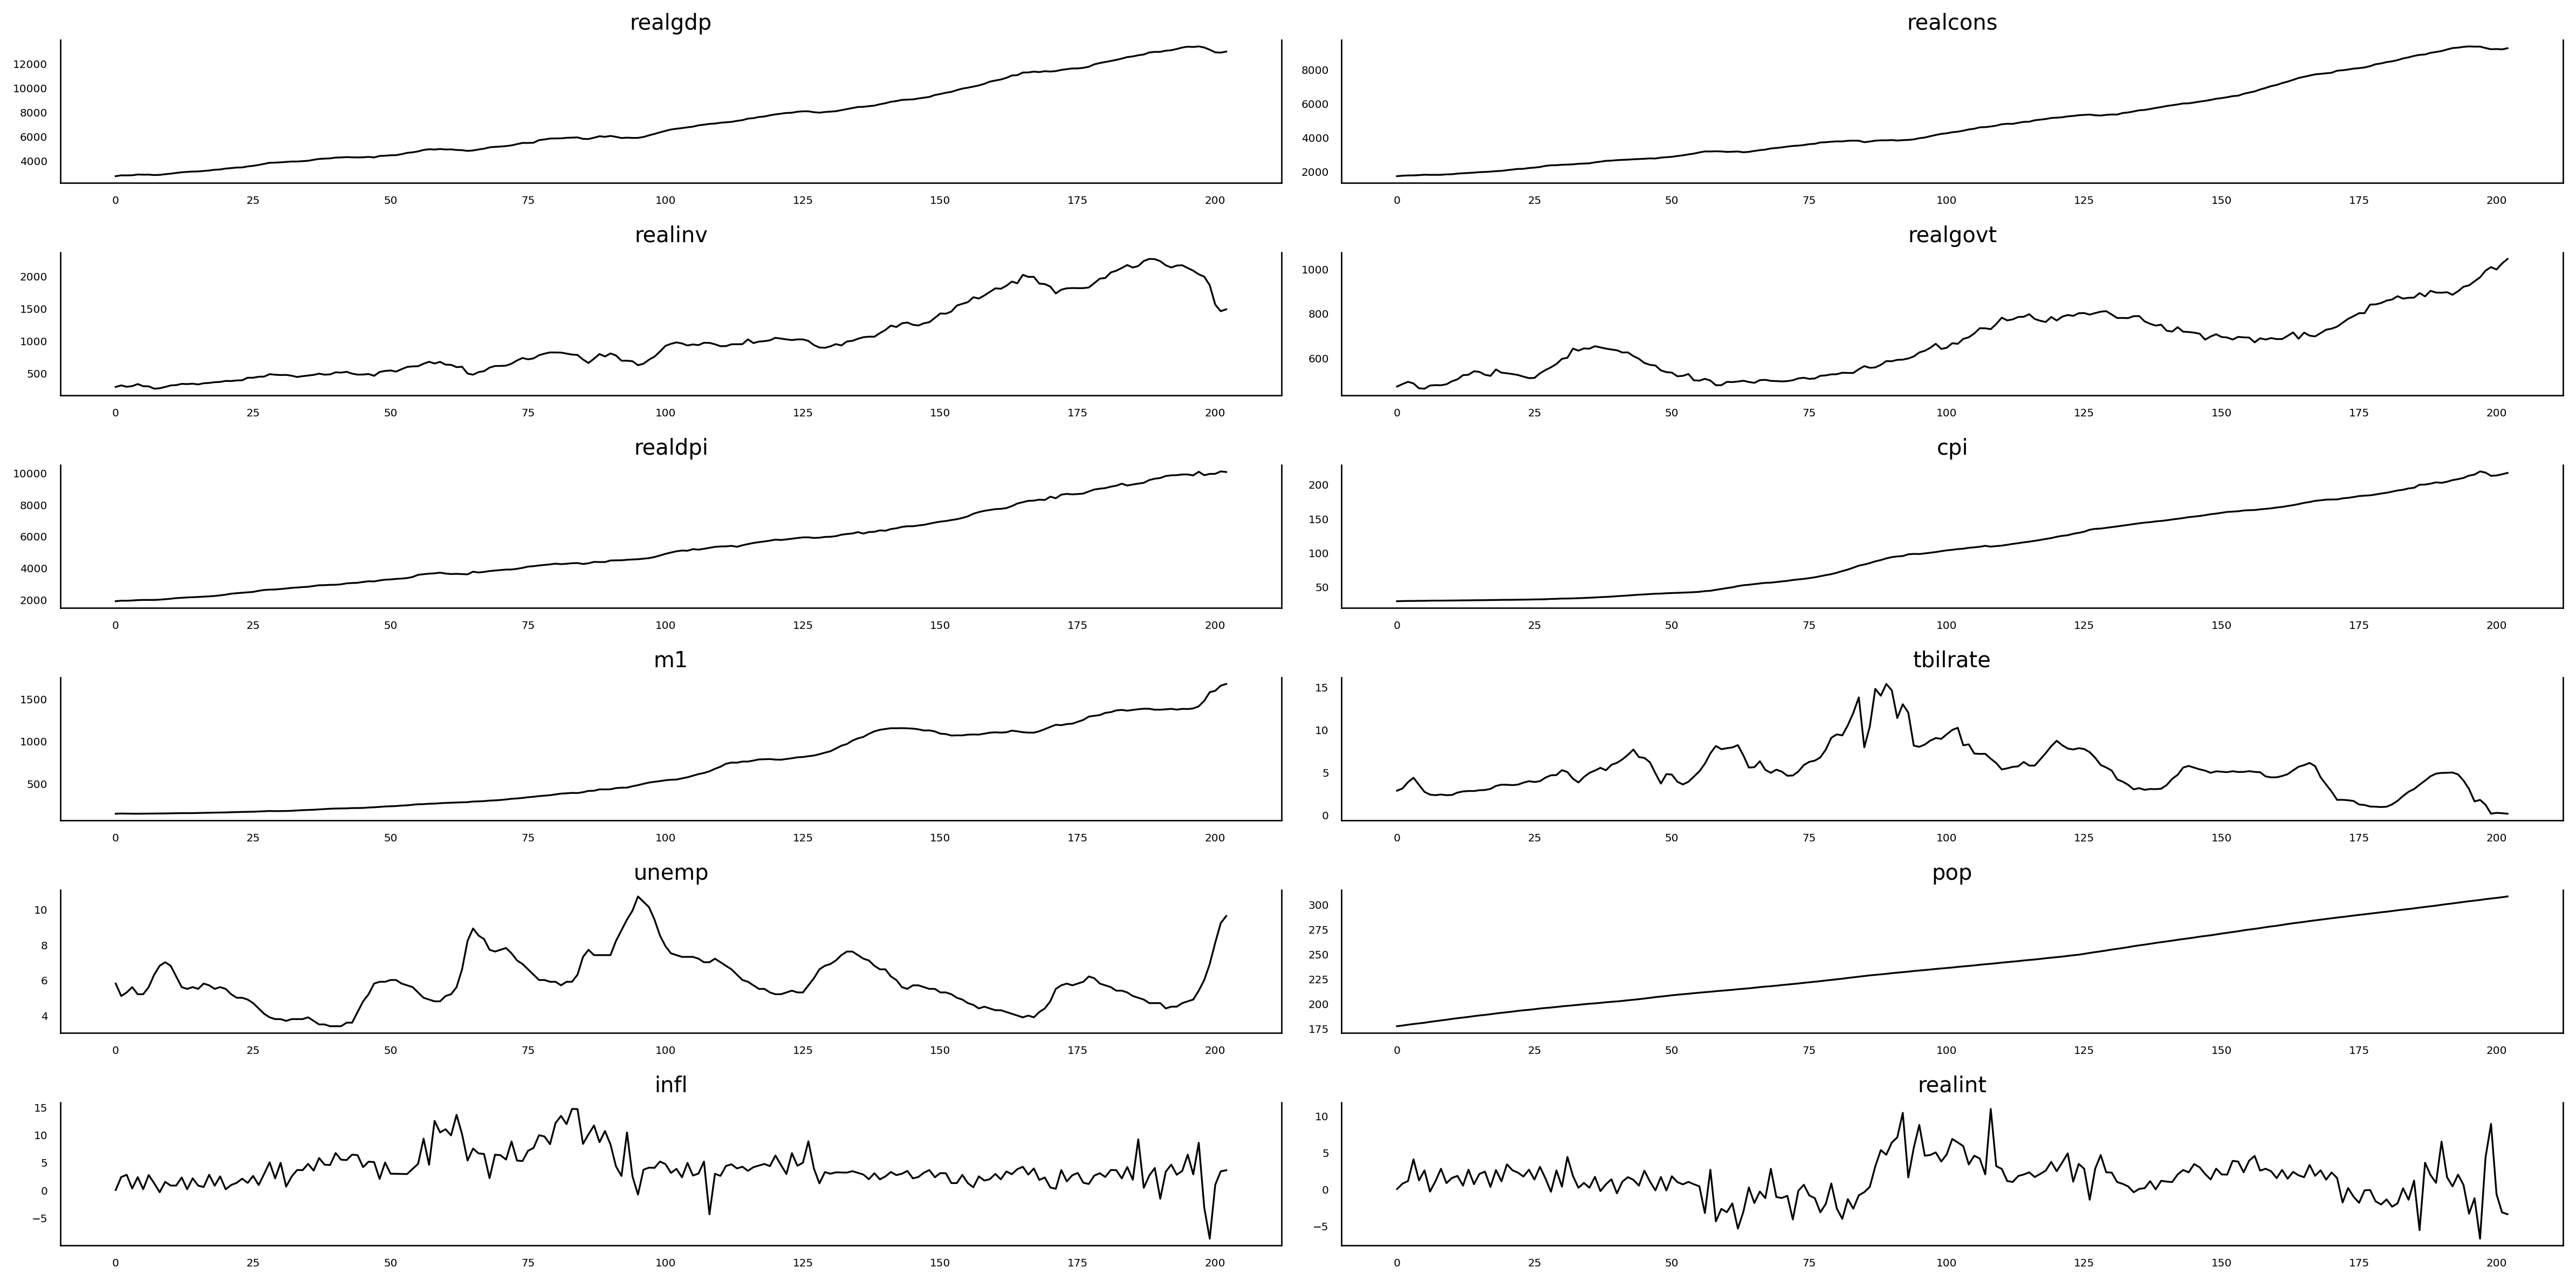

In [7]:
fig, axes = plt.subplots(nrows = 6, ncols = 2, dpi = 240)

for i, ax in enumerate(axes.flatten()):
    data = macro_data[macro_data.columns[i+2]]
    
    ax.plot(data, color = 'black', linewidth = 1)
    ax.set_title(macro_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize = 6)
    
plt.tight_layout()

In [8]:
macro_data['realgdp_tr1'] = macro_data['realgdp'].diff()

macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,realgdp_tr1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,68.452
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,-3.313
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,9.716
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,62.495


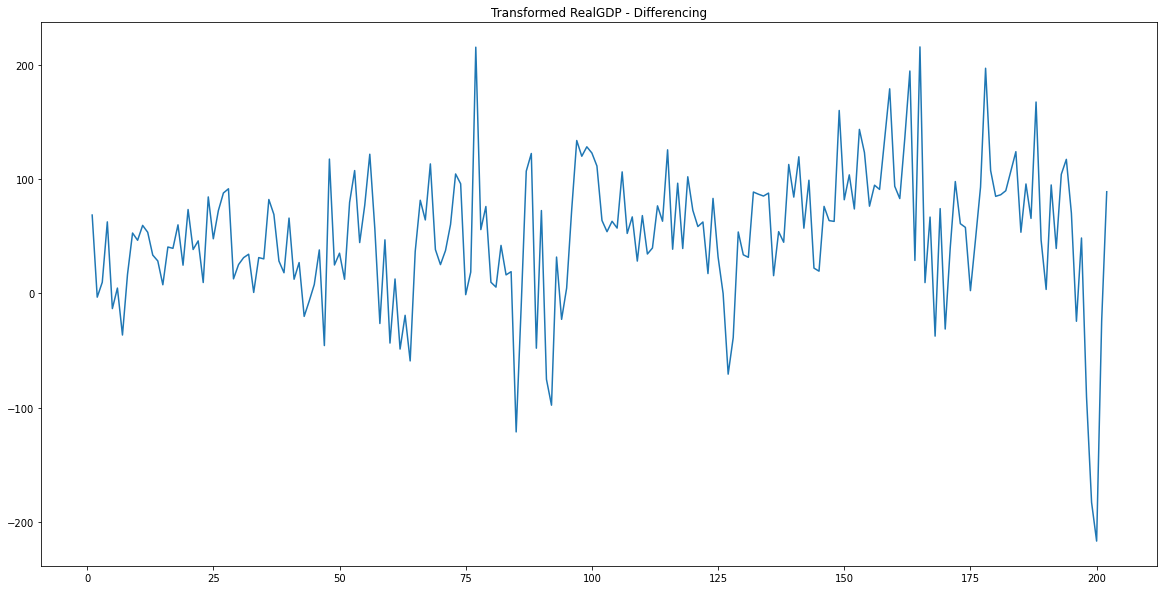

In [9]:
plt.plot(macro_data['realgdp_tr1'])
plt.title('Transformed RealGDP - Differencing')
plt.show()

In [10]:
ad_fuller_result = adfuller(macro_data['realgdp_tr1'][1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658105
p-value: 3.327882187668224e-08


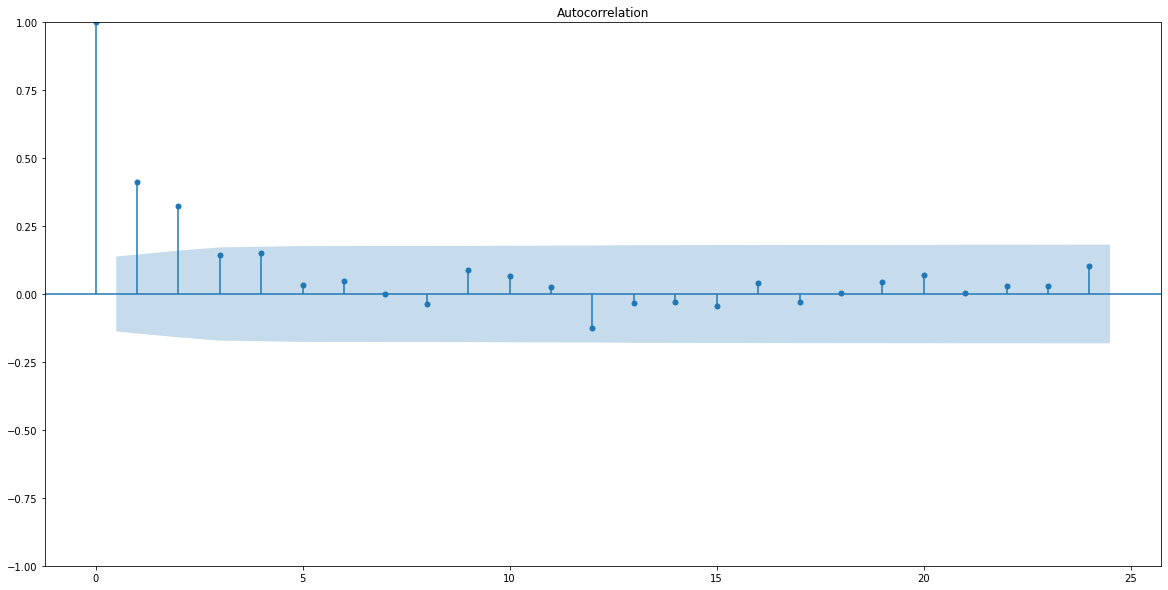

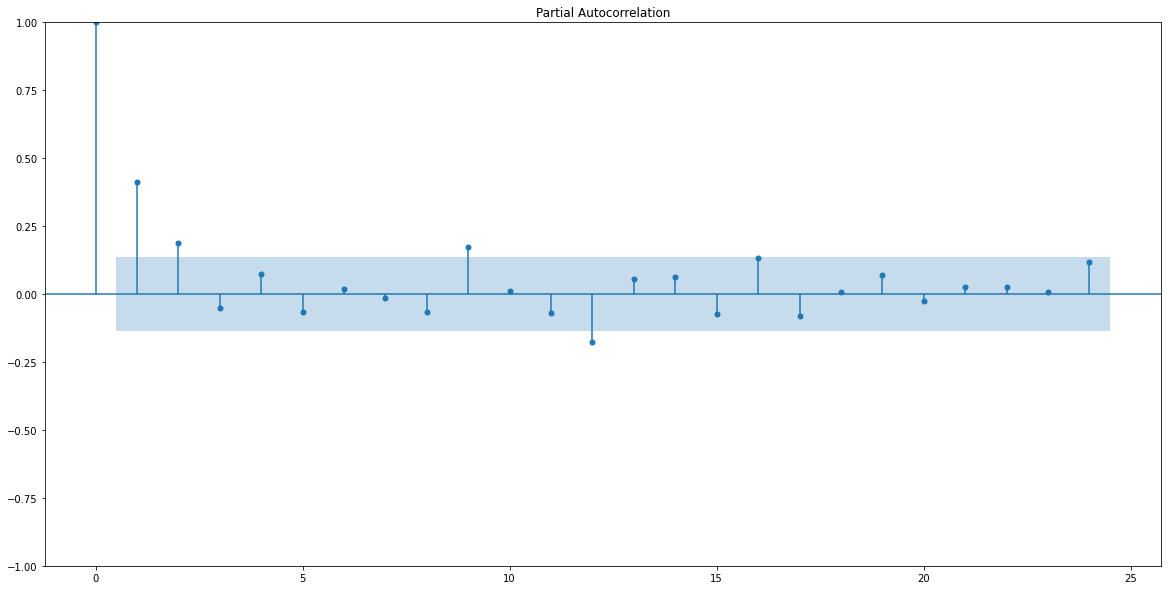

In [11]:
plot_acf(macro_data['realgdp_tr1'][1:]);
plot_pacf(macro_data['realgdp_tr1'][1:]);

In [12]:
def optimized_SARIMAX(endog, exog, parameters_list, d, D, s):
    """ 
        Returns dataframe with parameters, corresponding AIC
        
        endog - the observed variable
        exog - the exogenous variables
        parameters_list - list with (p, d, P, Q)
        d - integration order
        D - seasonal integration order
        s - length of the season
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order = (param[0], d, param[1]),
                seasonal_order = (param[2], D, param[3], s),
                simple_differencing = False
            ).fit(disp=False)
            
        except:
            continue
        
        aic = model.aic 
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop=True)
    
    return result_df

In [13]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)

s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [14]:
endog = macro_data['realgdp']
exog = macro_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]

In [15]:
result_df = optimized_SARIMAX(endog[:200], exog[:200], parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 2, 1, 0)",1757.237664
1,"(3, 3, 0, 0)",1757.813988
2,"(2, 2, 0, 2)",1758.330673
3,"(2, 2, 0, 0)",1759.104378
4,"(2, 2, 2, 0)",1759.861841
...,...,...
251,"(3, 2, 2, 1)",1776.806688
252,"(3, 2, 1, 3)",1776.867068
253,"(3, 2, 1, 1)",1776.944888
254,"(3, 2, 1, 2)",1778.131933


In [16]:
best_model = SARIMAX(
    endog, 
    exog, 
    order=(2,1,2), 
    seasonal_order = (1,0,0,4),
    simple_differencing = False
)

res = best_model.fit(dis=False)

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.37385D+00    |proj g|=  9.34287D-02

At iterate    5    f=  4.36851D+00    |proj g|=  7.22865D-03

At iterate   10    f=  4.36816D+00    |proj g|=  7.45320D-03

At iterate   15    f=  4.36609D+00    |proj g|=  5.55450D-02


 This problem is unconstrained.



At iterate   20    f=  4.36065D+00    |proj g|=  2.23272D-02

At iterate   25    f=  4.35570D+00    |proj g|=  1.05647D-02

At iterate   30    f=  4.35413D+00    |proj g|=  1.37444D-02

At iterate   35    f=  4.34755D+00    |proj g|=  5.81941D-02

At iterate   40    f=  4.34073D+00    |proj g|=  2.44455D-02

At iterate   45    f=  4.34026D+00    |proj g|=  5.08678D-03

At iterate   50    f=  4.33970D+00    |proj g|=  6.67528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     50     59      1     0     0   6.675D-03   4.340D+00
  F =   4.3397005126025290     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

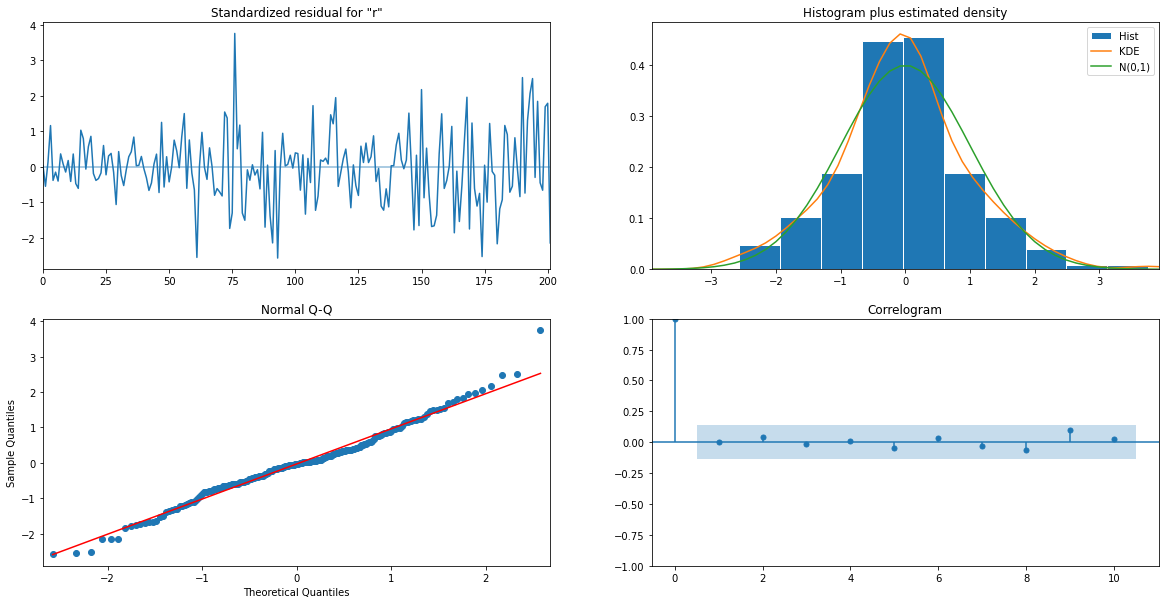

In [17]:
res.plot_diagnostics();

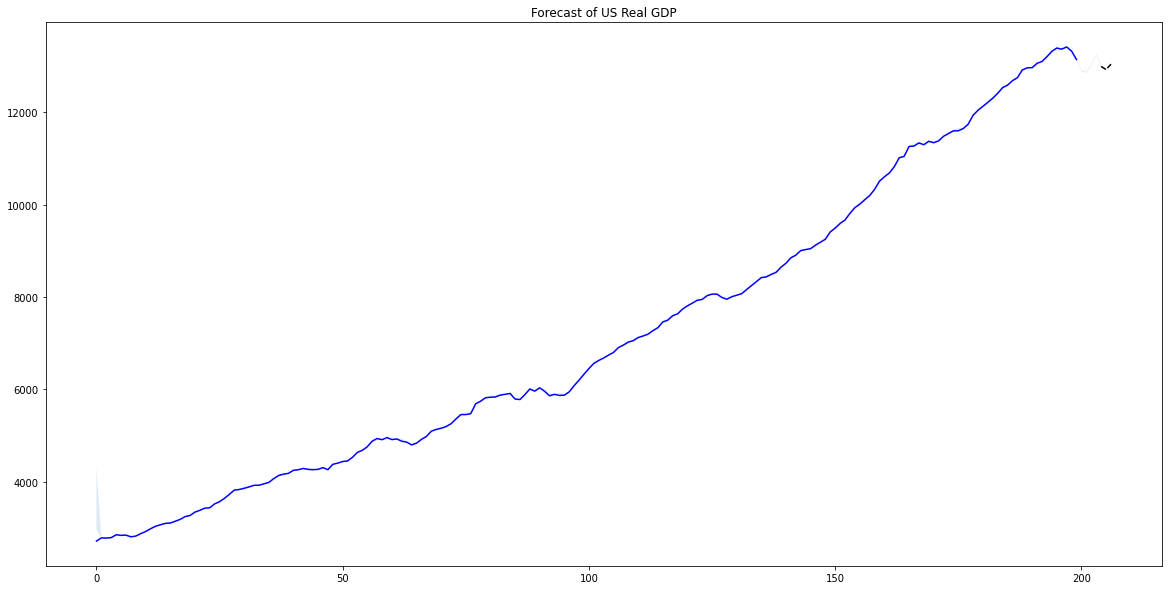

In [18]:
n_forecast = 3

predict = res.get_prediction(
    end = best_model.nobs + n_forecast,
    exog = exog.iloc[-4:]
)

idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha = 0.5)

fig, ax = plt.subplots()

ax.plot(macro_data['realgdp'][:200], color = 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha = 0.15)

ax.set_title('Forecast of US Real GDP')
plt.show()

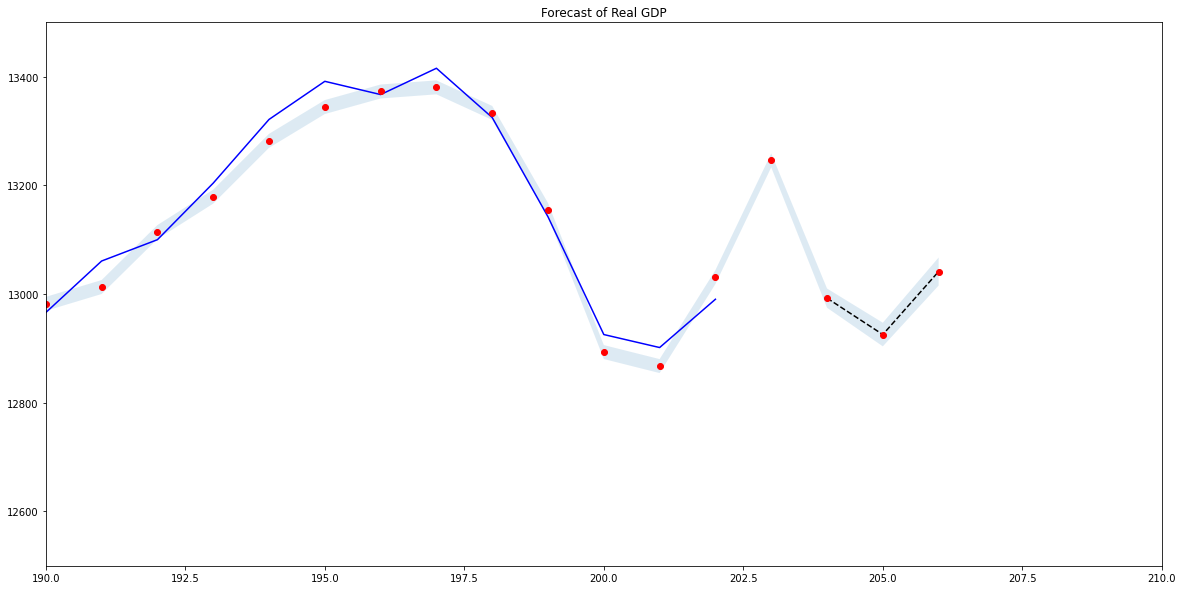

In [19]:
fig, ax = plt.subplots()
ax.plot(macro_data['realgdp'], color = 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.plot(predict.predicted_mean, 'ro')
ax.fill_between(idx, predict_ci.iloc[:,0], predict_ci.iloc[:,1], alpha = 0.15)

ax.set_xlim(190,210)
ax.set_ylim(12500,13500)

ax.set_title('Forecast of Real GDP')
plt.show()

In [20]:
mse = mean_squared_error(macro_data['realgdp'], predict.predicted_mean[:203])

print(f'MSE: {mse}')

MSE: 4638.882119172003


In [21]:
mape = np.mean(np.abs(macro_data['realgdp'] - predict.predicted_mean[:203]) / np.abs(macro_data['realgdp']))

print(f'Mean Absolute Percentage Error: {round(mape*100,2)}%')

Mean Absolute Percentage Error: 0.38%
